In [ ]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from IPython.display import display
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score



# Load the datasets
dir = os.getcwd()
training_data_path = os.path.join(dir, "2021plus_data_v1.csv")
prediction_data_path = os.path.join(dir, "2024_data_v4.csv")

training_data = pd.read_csv(training_data_path)
prediction_data = pd.read_csv(prediction_data_path)

# Preprocess training data
label_encoder_conf = LabelEncoder() #label encoder for conference names

label_encoder_postseason = LabelEncoder() #label encoder for postseason
training_data['POSTSEASON'] = label_encoder_postseason.fit_transform(training_data['POSTSEASON']) #encode to ints

X = training_data.drop(['Season', 'TeamName', 'POSTSEASON'], axis=1)
y = training_data['POSTSEASON']

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Training the RandomForest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

# Making predictions on the test set
y_pred = rf_model.predict(X_test_scaled)

# Calculating the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy: {accuracy}")

# Ensure all classes are represented, even those without predictions
all_classes = np.array(['R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champions'])  # Adjust as necessary
all_labels = label_encoder_postseason.transform(all_classes)

# Generate a classification report that includes all classes
class_report = classification_report(
    y_test, y_pred,
    labels=all_labels,
    target_names=all_classes,
    zero_division=0  # Avoid division by zero errors
)

print("Classification Report:\n", class_report)


# Adjusting the prediction process for the 2024 dataset
common_features = prediction_data.columns.intersection(X.columns).tolist()
X_train_common = X_train[common_features]
X_test_common = X_test[common_features]

# Re-scaling the features based on the common features set
scaler_common = StandardScaler()
X_train_common_scaled = scaler_common.fit_transform(X_train_common)
X_test_common_scaled = scaler_common.transform(X_test_common)

# Retraining the RandomForest model with the adjusted features
rf_model_common = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model_common.fit(X_train_common_scaled, y_train)

# Preparing the 2024 prediction data with the common features and appropriate scaling
prediction_data_processed = prediction_data[common_features]
prediction_data_scaled = scaler_common.transform(prediction_data_processed)

# Making initial predictions with the retrained RandomForest model
initial_predictions_common = rf_model_common.predict_proba(prediction_data_scaled)

# Convert initial predictions to a DataFrame
predictions_common_df = pd.DataFrame(initial_predictions_common, columns=label_encoder_postseason.classes_)
predictions_common_df['TeamName'] = prediction_data['TeamName']


# Updated constraints without R68
updated_constraints = {'Champions': 1, '2ND': 1, 'F4': 2, 'E8': 4, 'S16': 8, 'R32': 16, 'R64': 32}

# Function to adjust predictions to ensure uniqueness and meet stage constraints
def adjust_predictions_to_meet_constraints(predictions_df, constraints):
    final_assignments = pd.DataFrame(columns=['TeamName', 'PredictedStage'])
    assigned_teams = []

    for stage, count in constraints.items():
        available_predictions = predictions_df[~predictions_df['TeamName'].isin(assigned_teams)]
        top_teams_for_stage = available_predictions.nlargest(count, stage)[['TeamName']]
        top_teams_for_stage['PredictedStage'] = stage
        
        # Corrected approach for appending rows to the DataFrame
        final_assignments = pd.concat([final_assignments, top_teams_for_stage], ignore_index=True)
        
        assigned_teams.extend(top_teams_for_stage['TeamName'].tolist())

    # Ensure the final assignments are in a sensible order (optional, for readability)
    final_assignments['StageOrder'] = final_assignments['PredictedStage'].apply(lambda x: list(constraints.keys()).index(x))
    final_assignments = final_assignments.sort_values('StageOrder').drop('StageOrder', axis=1).reset_index(drop=True)

    return final_assignments

# Call the new adjustment function
final_adjusted_predictions = adjust_predictions_to_meet_constraints(predictions_common_df, updated_constraints)

# Display the adjusted predictions
print(final_adjusted_predictions)

final_adjusted_predictions.to_csv("final_predictions.csv", index=False)



Model accuracy: 0.43902439024390244
Classification Report:
               precision    recall  f1-score   support

         R64       0.58      0.70      0.64        20
         R32       0.18      0.29      0.22         7
         S16       1.00      0.20      0.33         5
          E8       0.00      0.00      0.00         5
          F4       1.00      1.00      1.00         1
         2ND       0.00      0.00      0.00         0
   Champions       0.00      0.00      0.00         1

   micro avg       0.44      0.46      0.45        39
   macro avg       0.40      0.31      0.31        39
weighted avg       0.49      0.46      0.43        39

            TeamName PredictedStage
0        Connecticut      Champions
1            Arizona            2ND
2            Florida             F4
3            Houston             F4
4           Iowa St.             E8
..               ...            ...
59      Morehead St.            R64
60  South Dakota St.            R64
61     Grambling St

In [33]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
    'max_features': ['auto', 'sqrt'],  # Number of features to consider when looking for the best split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with the parameter grid, RandomForest model, and other configurations
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters found by GridSearchCV
print(f"Best parameters: {grid_search.best_params_}")

# Use the best estimator to make predictions on the test set
y_pred = grid_search.predict(X_test_scaled)

# Recalculate metrics using the optimized model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print the recalculated metrics
print(f"Model Accuracy: {accuracy}")
print(f"Model Precision: {precision}")
print(f"Model Recall: {recall}")
print(f"Model F1 Score: {f1}")

# Generate and print the classification report for the optimized model
class_report = classification_report(y_test, y_pred, labels=all_labels, target_names=all_classes, zero_division=0)
print("Model Classification Report:\n", class_report)


Fitting 3 folds for each of 216 candidates, totalling 648 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED

[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.1s
[CV] END max_depth=None, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END max_depth=None, max_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature Importances:
         Feature  Importance
11        AdjEM    0.081973
17            G    0.062054
23         SEED    0.057273
24  FUTURE_ODDS    0.056770
0      de_TOPct    0.053629
10        AdjDE    0.049561
20         3P_O    0.041863
22          WAB    0.041673
5       o_ORPct    0.040245
4       o_TOPct    0.037589
15        Def_3    0.037471
21         3P_D    0.036253
7         Tempo    0.036056
2     de_FTRate    0.034506
1      de_ORPct    0.034236
9            DE    0.033289
6      o_FTRate    0.032349
19         2P_D    0.031925
14        Def_2    0.031124
12        Off_2    0.030960
13        Off_3    0.029538
3      o_eFGPct    0.028295
8            OE    0.028291
18            W    0.026566
16         CONF    0.026509


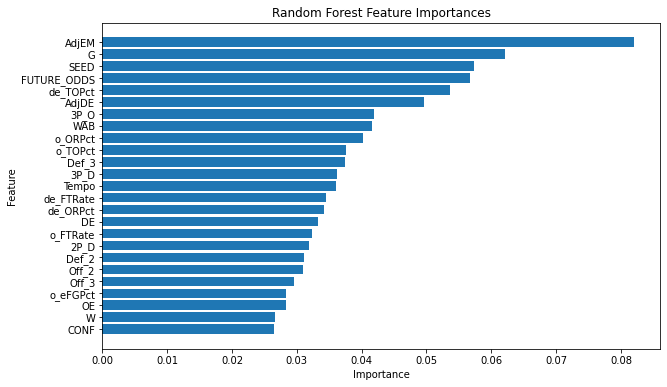

In [ ]:
# Assuming 'X' is your DataFrame of features used in training the RandomForest model
feature_importances = rf_model.feature_importances_

X = training_data.drop(['Season', 'TeamName', 'POSTSEASON'], axis=1)

# 'X.columns' should already contain only the features involved in the prediction
feature_names = X.columns

# Create a DataFrame to hold the feature importances
importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame to show the most important features at the top
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:\n", importances_df)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importances_df['Feature'], importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.title('Random Forest Feature Importances')
plt.show()


/var/folders/fs/g9ydf4hn48ng21n8dv53yt380000gn/T/ipykernel_84887/3886582321.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  constrained_probs = pd.DataFrame(index=final_assignments['TeamName'], columns=updated_constraints.keys()).fillna(0)
/var/folders/fs/g9ydf4hn48ng21n8dv53yt380000gn/T/ipykernel_84887/3886582321.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.21' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  constrained_probs.at[team_name, stage] = prob
/var/folders/fs/g9ydf4hn48ng21n8dv53yt380000gn/T/ipykernel_84887/3886582321.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a fut

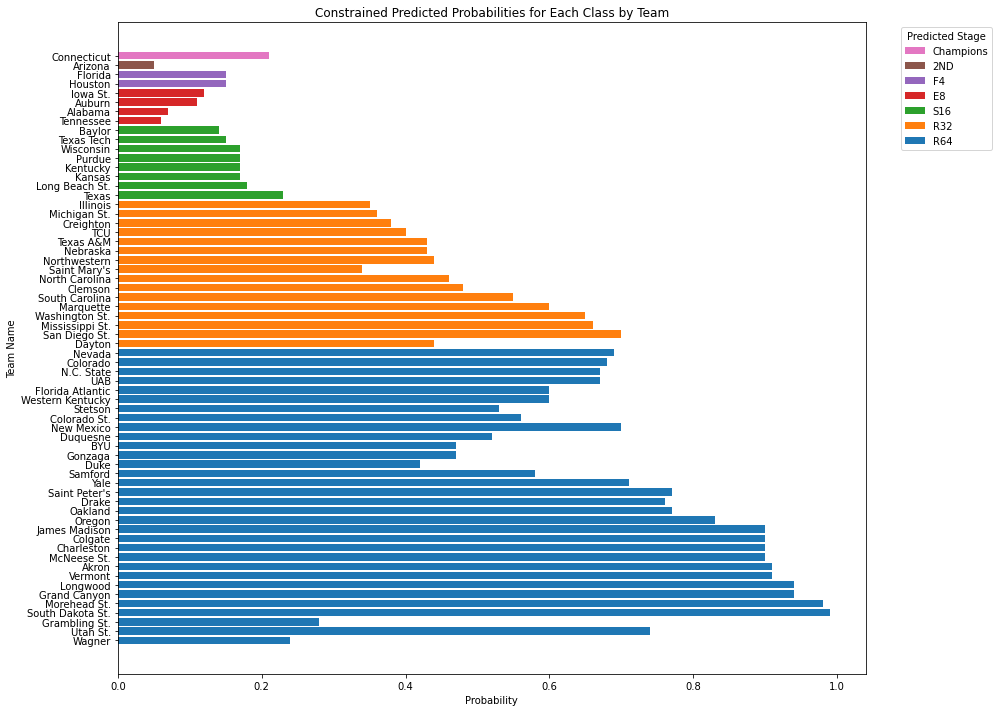

In [ ]:
import matplotlib.pyplot as plt

final_assignments = adjust_predictions_to_meet_constraints(predictions_common_df, updated_constraints)

# Set the figure size for the plot
plt.figure(figsize=(14, 10))

# Create a new DataFrame to store the constrained probabilities
constrained_probs = pd.DataFrame(index=final_assignments['TeamName'], columns=updated_constraints.keys()).fillna(0)

# Map the constrained stages to their probabilities
for index, row in final_assignments.iterrows():
    team_name = row['TeamName']
    stage = row['PredictedStage']
    prob = predictions_common_df.loc[predictions_common_df['TeamName'] == team_name, stage].values[0]
    constrained_probs.at[team_name, stage] = prob

# Define the colors for each stage
colors = {
    'R64': '#1f77b4', 
    'R32': '#ff7f0e', 
    'S16': '#2ca02c', 
    'E8': '#d62728', 
    'F4': '#9467bd', 
    '2ND': '#8c564b', 
    'Champions': '#e377c2'
}

# Plot the probabilities using a horizontal bar chart
for stage in updated_constraints.keys():
    # Use the color from the colors dictionary
    plt.barh(constrained_probs.index, constrained_probs[stage], color=colors[stage], label=stage)

# Add a legend, labels, and title to the plot
plt.legend(title='Predicted Stage', bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Probability')
plt.ylabel('Team Name')
plt.title('Constrained Predicted Probabilities for Each Class by Team')
plt.gca().invert_yaxis()  # Display the highest probability at the top
plt.tight_layout()  # Adjust the layout

# Show the plot
plt.show()


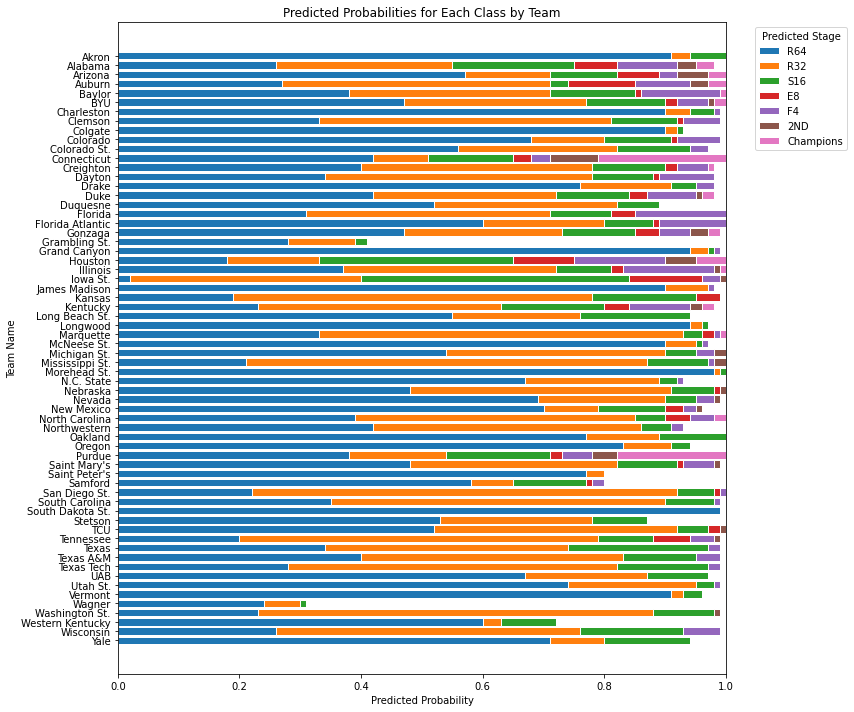

In [ ]:
import matplotlib.pyplot as plt

# Set the size of the figure
plt.figure(figsize=(12, 10))

# Define the order of stages and corresponding colors (modify if needed)
stages = ['R64', 'R32', 'S16', 'E8', 'F4', '2ND', 'Champions']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Starting position for the first set of bars
left = np.zeros(len(predictions_common_df))

# Plot each stage's predicted probabilities in a stacked manner
for stage, color in zip(stages, colors):
    plt.barh(predictions_common_df['TeamName'], predictions_common_df[stage], left=left, color=color, edgecolor='white', label=stage)
    left += predictions_common_df[stage]  # Increment the left position for the next stack

# Add the legend, title, and labels
plt.legend(title='Predicted Stage', bbox_to_anchor=(1.04,1), loc="upper left")
plt.xlabel('Predicted Probability')
plt.ylabel('Team Name')
plt.title('Predicted Probabilities for Each Class by Team')
plt.gca().invert_yaxis()  # Invert the y-axis to show the team with the highest probability at the top
plt.tight_layout()  # Adjust the layout

# Display the plot
plt.show() 
